In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

# Examples: Data Processing

This is a trivial example of how to create data for CNSistent, fill missing segments, impute missing values, create consistent segmentation, aggregate the values and plot the results.

We will go through the following steps:
1. Create data
2. Fill missing segments
3. Infer missing values
4. Create consistent segmentation
5. Aggregate the values

In [2]:
%load_ext autoreload
%autoreload 2

import io
import pandas as pd

# Import the cns module
import cns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create data

Firs we create two SCNA profiles for samples s1, s2 with copy number columns CN1, CN2.

For the tutorial we will limit ourselves to chr19.

In [3]:
cns_source = """sample_id, chrom, start, end, CN1, CN2
s1, chr19, 1000000, 3000000, 1,
s1, chr19, 3000000, 12000000, 1, 1
s1, chr19, 12000000, 14000000, , 1
s1, chr19, 14000000, 21000000, 3, 1
s1, chr19, 21000000, 25000000, 3, 
s1, chr19, 28000000, 58500000, 3,
s2, chr19, 1000000, 24000000, 2,
s2, chr19, 29000000, 58000000, 0,
"""
raw_cns_df = pd.read_csv(io.StringIO(cns_source.strip()), sep=',\s*', engine='python')
raw_cns_df.head()

,sample_id,chrom,start,end,CN1,CN2
0,s1,chr19,1000000,3000000,1.0,NaN
1,s1,chr19,3000000,12000000,1.0,1.0
2,s1,chr19,12000000,14000000,NaN,1.0
3,s1,chr19,14000000,21000000,3.0,1.0
4,s1,chr19,21000000,25000000,3.0,NaN


We plot heatmaps of the above values, note that the positions are on the linear genome.

(<Figure size 300x300 with 2 Axes>,
 array([<Axes: xlabel='CN1'>, <Axes: xlabel='CN2'>], dtype=object))

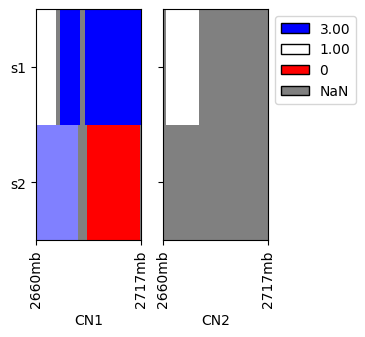

In [4]:
cns.fig_heatmap(raw_cns_df)

For real datasets we would need to limit ourselves to a subset of a data for visualization purposes, e.g.:

(<Figure size 300x300 with 2 Axes>,
 array([<Axes: ylabel='CN1'>,
        <Axes: xlabel='position on the linear genome', ylabel='CN2'>],
       dtype=object))

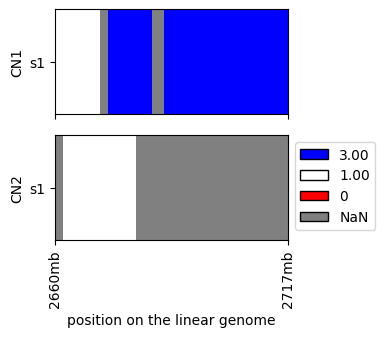

In [5]:
cns.fig_heatmap(cns.cns_head(raw_cns_df, 1))

## Coverage and filling

Next we will analyze missing segments and fill them with the average value of the surrounding segments.

Since we are only focusing on chr19, we create a mask for chr19 only.

In [6]:
chr19_seg = cns.make_segments("chr19")
print(chr19_seg)

{'chr19': [(0, 59128983, 'chr19')]}


First we calculate the proportion of missing segments:

In [7]:
cover_df = cns.main_coverage(raw_cns_df, segs=chr19_seg)
cover_df.head()

,sex,chrom_count,chrom_missing,cover_any_aut,cover_any_sex,cover_any_all,cover_both_aut,cover_both_sex,cover_both_all
sample_id,,,,,,,,,
s1,xx,1,[],0.921714,0,0.921714,0.270595,0,0.270595
s2,xx,1,[],0.879433,0,0.879433,0.000000,0,0.000000


Then we fill the missing segments with NaN values:

In [8]:
chr19_seg["chr19"] = cns.genome_to_segments()["chr19"]
align_cns_df = cns.main_align(raw_cns_df, segs=chr19_seg)
align_cns_df.head()

,sample_id,chrom,start,end,CN1,CN2,name
0,s1,chr19,0,1000000,NaN,NaN,chr19
1,s1,chr19,1000000,3000000,1.0,NaN,chr19
2,s1,chr19,3000000,12000000,1.0,1.0,chr19
3,s1,chr19,12000000,14000000,NaN,1.0,chr19
4,s1,chr19,14000000,21000000,3.0,1.0,chr19


When plotting we can see that the data are now extended to the boundaries of chromosome 19

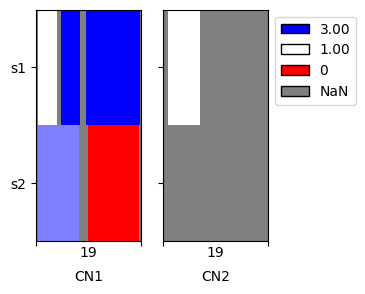

In [9]:
cns.fig_heatmap(align_cns_df, cn_columns=['CN1', 'CN2']);

## Imputation and aneuploidy

Next we fill values into the missing segments. 

Leading and trailing NaN values are filled with the first and last non-NaN value, respectively. 

The remaining NaN values are filled with the mean of the non-NaN values.

In [10]:
imp_cns_df = cns.main_infer(align_cns_df)
imp_cns_df.head()

,sample_id,chrom,start,end,CN1,CN2
0,s1,chr19,0,13000000,1.0,1.0
1,s1,chr19,13000000,59128983,3.0,1.0
2,s2,chr19,0,26500000,2.0,0.0
3,s2,chr19,26500000,59128983,0.0,0.0


We can see that the number of segments decreased considerably, to only 2 actual breakpoints, which we can see on the imputed plot.

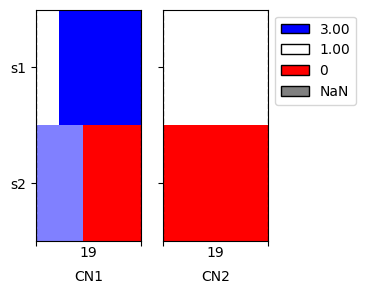

In [11]:
cns.fig_heatmap(imp_cns_df, cn_columns=['CN1', 'CN2']);

We expect that the imputed data are more representative of the actual genome, therefore we preferably analyze the imputed data further.

In [26]:
ploidy_df = cns.main_ploidy(imp_cns_df)
ploidy_df.head()

,sex,loh_both_aut,loh_any_aut,ane_any_aut,ane_both_aut,imb_CN1_aut,imb_CN2_aut,ploidy_CN1,ploidy_CN2
sample_id,,,,,,,,,
s1,xx,0.000000,0.000000,0.016011,0.000000,0.016011,0.0,2.560283,1.0
s2,xx,0.011325,0.020524,0.020524,0.020524,0.009198,0.0,0.896346,0.0


Similarly, we can calculate information about breakpoints. 
Note that the "total_cn" column is added to the data for the calculation:

In [28]:
breakage_df = cns.main_breakage(imp_cns_df)
breakage_df.head()

,sex,breaks_CN1_aut,step_CN1_aut,breaks_CN2_aut,step_CN2_aut,breaks_total_cn_aut,step_total_cn_aut
sample_id,,,,,,,
s1,xx,1,2.0,0,0,1,2.0
s2,xx,1,2.0,0,0,1,2.0


## Segment and aggregate

First we create a consistent segmentation of the data. Since there are two breakpoints, we will have three segments.

In [31]:
mcs_segs = cns.cns_df_to_segments(imp_cns_df, process="unify")
mcs_segs

{'chr19': [(0, 13000000, 'chr19_0'),
  (13000000, 26500000, 'chr19_1'),
  (26500000, 59128983, 'chr19_2')]}

Using the segmentation, we can aggregate the values of the segments.

In [32]:
mcs_agg_df = cns.main_aggregate(imp_cns_df, mcs_segs)
mcs_agg_df


,sample_id,chrom,start,end,CN1,CN2,name
0,s1,chr19,0,13000000,1.0,1.0,chr19_0
1,s1,chr19,13000000,26500000,3.0,1.0,chr19_1
2,s1,chr19,26500000,59128983,3.0,1.0,chr19_2
3,s2,chr19,0,13000000,2.0,0.0,chr19_0
4,s2,chr19,13000000,26500000,2.0,0.0,chr19_1
5,s2,chr19,26500000,59128983,0.0,0.0,chr19_2


We then use fig_bars as it shows the exact segmentation points.

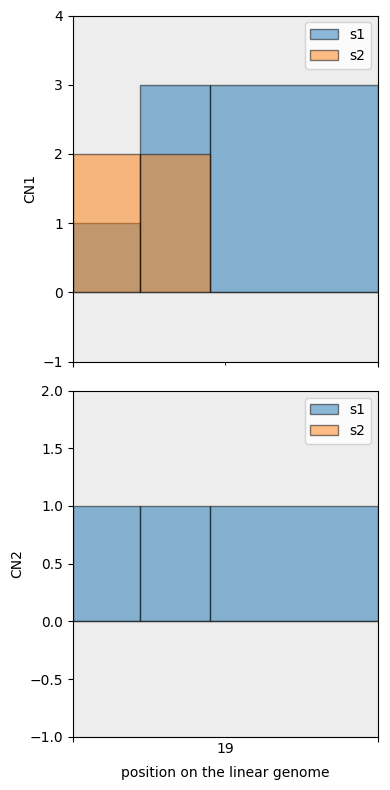

In [33]:
cns.fig_bars(mcs_agg_df);

## Splitting and filtering

Here we further explore the segmentation by removing regions of low mappability (gaps) and splitting the segments into smaller ones.

First we load the gap regions.

In [34]:
gap_segs = cns.make_segments("gaps")
gap_segs["chr19"]

[(0, 10000, 'telomere'),
 (10000, 60000, 'contig'),
 (7346004, 7396004, 'contig'),
 (8687198, 8737198, 'contig'),
 (20523415, 20573415, 'clone'),
 (24631782, 24681782, 'heterochromatin'),
 (24681782, 27681782, 'centromere'),
 (27681782, 27731782, 'heterochromatin'),
 (59118983, 59128983, 'telomere')]

We then conduct the segmentation with the following:

* 10 kb filtering will ignore gaps below this size
* applying the gaps will remove the regions that overlap with the gaps
* the remainder is split into segments of 3 mb

In [35]:
complex_segs = cns.main_segment(mcs_segs, remove_segs=gap_segs, split_size=3*10**6, filter_size=10**5)
complex_segs["chr19"][:5]

[(0, 3250000, 'chr19_0_0'),
 (3250000, 6500000, 'chr19_0_1'),
 (6500000, 9750000, 'chr19_0_2'),
 (9750000, 13000000, 'chr19_0_3'),
 (13000000, 15907946, 'chr19_1_0')]

We again aggregated the CNs into the segments.

In [36]:
complex_agg_df = cns.main_aggregate(imp_cns_df, complex_segs)
complex_agg_df.head()

,sample_id,chrom,start,end,CN1,CN2,name
0,s1,chr19,0,3250000,1.0,1.0,chr19_0_0
1,s1,chr19,3250000,6500000,1.0,1.0,chr19_0_1
2,s1,chr19,6500000,9750000,1.0,1.0,chr19_0_2
3,s1,chr19,9750000,13000000,1.0,1.0,chr19_0_3
4,s1,chr19,13000000,15907946,3.0,1.0,chr19_1_0


And display the segmentation. This time we first add a sum column to the data and only plot that one (total copy number).

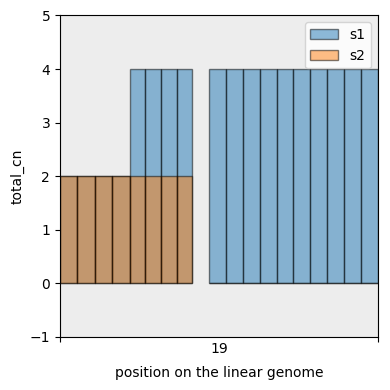

In [37]:
with_total_cn_df = cns.add_total_cn(complex_agg_df)
cns.fig_bars(with_total_cn_df, cn_columns='total_cn');

For more fine grained segmentations we can also plot CN lines. Note the interpolation between neighbours.

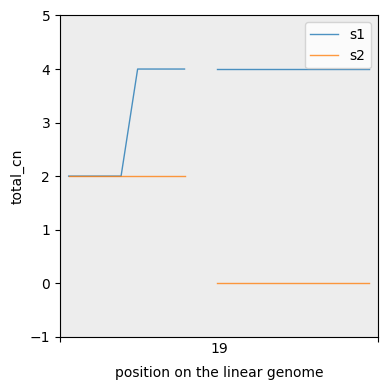

In [38]:
cns.fig_lines(with_total_cn_df, cn_columns="total_cn");

## Conversions

Below we show conversions between data formats.

This is in particular useful for data processing pipelines, where we might want to have our data as feature sets. 
These can be then fed into machine learning models.

In [39]:
features, samples, positions = cns.bins_to_features(complex_agg_df)
print(features.shape)
print(samples)
positions.head()

(2, 3, 18)
['s1', 's2']


,chrom,start,end
name,,,
chr19_0_0,chr19,0,3250000
chr19_0_1,chr19,3250000,6500000
chr19_0_2,chr19,6500000,9750000
chr19_0_3,chr19,9750000,13000000
chr19_1_0,chr19,13000000,15907946


Conversions between segments and CNS_df:

In [41]:
cns.cns_df_to_segments(complex_agg_df)["chr19"]

[(0, 3250000, 'chr19_0_0'),
 (3250000, 6500000, 'chr19_0_1'),
 (6500000, 9750000, 'chr19_0_2'),
 (9750000, 13000000, 'chr19_0_3'),
 (13000000, 15907946, 'chr19_1_0'),
 (15907946, 18815891, 'chr19_1_1'),
 (18815891, 21723837, 'chr19_1_2'),
 (21723837, 24631782, 'chr19_1_3'),
 (27731782, 30871502, 'chr19_2_0'),
 (30871502, 34011222, 'chr19_2_1'),
 (34011222, 37150942, 'chr19_2_2'),
 (37150942, 40290662, 'chr19_2_3'),
 (40290662, 43430383, 'chr19_2_4'),
 (43430383, 46570103, 'chr19_2_5'),
 (46570103, 49709823, 'chr19_2_6'),
 (49709823, 52849543, 'chr19_2_7'),
 (52849543, 55989263, 'chr19_2_8'),
 (55989263, 59128983, 'chr19_2_9'),
 (0, 3250000, 'chr19_0_0'),
 (3250000, 6500000, 'chr19_0_1'),
 (6500000, 9750000, 'chr19_0_2'),
 (9750000, 13000000, 'chr19_0_3'),
 (13000000, 15907946, 'chr19_1_0'),
 (15907946, 18815891, 'chr19_1_1'),
 (18815891, 21723837, 'chr19_1_2'),
 (21723837, 24631782, 'chr19_1_3'),
 (27731782, 30871502, 'chr19_2_0'),
 (30871502, 34011222, 'chr19_2_1'),
 (34011222, 371509

In [42]:
cns.segments_to_cns_df(gap_segs).head()

,sample_id,chrom,start,end,name,cn
0,segment,chr1,0,10000,telomere,2
1,segment,chr1,177417,227417,clone,2
2,segment,chr1,267719,317719,contig,2
3,segment,chr1,471368,521368,contig,2
4,segment,chr1,2634220,2684220,clone,2


Conversion between segments and breakpoints:

In [43]:
cns.segments_to_breaks(gap_segs)["chr19"][:5]

[0, 10000, 60000, 7346004, 7396004]

In [44]:
cns.breaks_to_segments({"chr19" : [0, 10000, 30000]})

{'chr19': [(0, 10000, 'chr19_0'), (10000, 30000, 'chr19_1')]}